# Feature Selection
Time to exact some audio features! I'm going to be using librosa to collect the following features from each audio clip:
- **mel-frequency spectrogram**: power spectrum of the sound.
- **chroma_features**: descibes the energy of each pitch class.
- **spectral centroid**: sort of like the "center of mass" of the sound, the frequency that the spectrum is centered on.
- **spectral bandwidth**: the width of the band of light at one-half the peak maximum.
- **spectral roll off**: the shape of the signal.
- **zero crossing rate**: measures the smoothness of the signal.
- **mel-frequency cepstral coefficients**: describes the shape of the spectral envelope.

In [1]:
# Import Packages
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Audio Processing
import librosa
import librosa.feature as lf
import librosa.display as ld
import sounddevice as sd
import soundfile as sf

In [2]:
def change_sample_rate(clip,samplerate,target):
    """Changes sample rate to the target"""
    if samplerate == 48000:
        resample=[]
        new_ratio = int(len(clip)/(len(clip) - target*(len(clip)/samplerate)))
        for n,num in enumerate(clip):
            if n % new_ratio != 0:
                resample.append(num)
    if samplerate == 16000:
        resample=[]
        for n,num in enumerate(clip):
            resample.append(num)
            try:
                mean = (num+clip[n+1])/2
                resample.append(mean)
            except:
                pass
    return np.array(resample), target

In [3]:
# open the legend
data = pd.read_csv('Data/CSVs/Audio Legend Clean.csv',index_col='Unnamed: 0')

# Get Features
open wav files and save features in a dataframe.

In [4]:
columns = ['filename','audio','sample rate','mel spectrogram','chroma','centroid','bandwidth',
           'roll off','zero crossing','mel cepstral']

audio = pd.DataFrame(columns=columns)
error = []

folders = 'Data/Audio/Clean/'
for count,track in enumerate(data['filename'],start=1):
    # get autio and sample rate
    path = folders+track
    clip, samplerate = sf.read(path)
    clip, samplerate = change_sample_rate(clip,samplerate,32000)
    try:
        L = [track,clip,samplerate,
             lf.melspectrogram(clip,samplerate),      # mel-frequency spectrogram
             lf.chroma_stft(clip,samplerate),         # chroma features
             lf.spectral_centroid(clip,samplerate),   # spectral centroid
             lf.spectral_bandwidth(clip,samplerate),  # spectral bandwidth
             lf.spectral_rolloff(clip,samplerate),    # spectral roll off
             lf.zero_crossing_rate(clip),             # zero crossing rate
             lf.mfcc(clip,samplerate)]                # mel-frequency cepstral coefficients
        audio = audio.append(dict(zip(columns,L)),ignore_index=True)
    except:
        error.append(track)
    
    # progress bar
    print('%4d of %4d complete (%d%%)' % (count,len(data['filename']),(count/len(data['filename']))*100)
          ,end='\r')
    
audio.index = pd.RangeIndex(0,len(audio))
audio.head()

,filename,audio,sample rate,mel spectrogram,chroma,centroid,bandwidth,roll off,zero crossing,mel cepstral
0,Clip_0000.wav,"[0.00531005859375, 0.0052337646484375, 0.00515...",32000,"[[0.004090846955342997, 0.0022982444898001506,...","[[0.5066218526861577, 0.5612419683730443, 0.36...","[[3323.0496203452876, 3684.8185241532246, 2713...","[[3353.369649525211, 3255.757920960339, 2946.2...","[[7093.75, 7250.0, 4187.5, 3875.0, 3750.0, 312...","[[0.04345703125, 0.0595703125, 0.0830078125, 0...","[[-408.1160667427661, -259.7704328627665, -139..."
1,Clip_0001.wav,"[0.002044677734375, 0.000823974609375, -0.0003...",32000,"[[0.00029370716437641573, 0.001453398555671830...","[[0.4785327570444342, 0.5347698002586199, 1.0,...","[[3142.845607605387, 2276.189090228854, 1929.6...","[[3013.908087104403, 2755.4262289479343, 2507....","[[4453.125, 3984.375, 3125.0, 2859.375, 2843.7...","[[0.048828125, 0.0634765625, 0.08056640625, 0....","[[-283.91790552406616, -253.3082395742626, -20..."
2,Clip_0002.wav,"[0.00640869140625, 0.0057830810546875, 0.00515...",32000,"[[0.00045832438238250047, 0.021327551938308143...","[[0.5818982230015957, 0.5353948465221252, 0.47...","[[2451.1851541432297, 2060.2634420868335, 2237...","[[2923.826926490095, 2608.569888244772, 2684.0...","[[4546.875, 3625.0, 3953.125, 3828.125, 3281.2...","[[0.04052734375, 0.06201171875, 0.0791015625, ...","[[-232.67525803815735, -147.78196238094785, -9..."
3,Clip_0003.wav,"[-0.0062255859375, -0.00579833984375, -0.00537...",32000,"[[0.007024909915790828, 0.007478870527619079, ...","[[0.41755322611994866, 0.16738115296548345, 0....","[[2517.9051249214926, 2113.140333122745, 2039....","[[2951.401401388755, 2715.2068162340315, 2635....","[[4109.375, 3812.5, 3750.0, 3796.875, 3453.125...","[[0.03955078125, 0.0537109375, 0.06640625, 0.0...","[[-234.0184717552555, -170.22585061647885, -11..."
4,Clip_0004.wav,"[-0.008636474609375, -0.0084075927734375, -0.0...",32000,"[[0.011095474383145267, 0.006937758212386692, ...","[[0.2422535923913532, 0.8484158502356332, 0.85...","[[3940.792377294914, 3027.6717817502004, 1970....","[[3220.166794250264, 3134.1541147241264, 2593....","[[7390.625, 5140.625, 3578.125, 2968.75, 3109....","[[0.0419921875, 0.05322265625, 0.06591796875, ...","[[-336.6271186955317, -282.9963816628331, -243..."


# Example
Listen to an audio clip and visualize the various features.

In [5]:
# Get a random audio clip
n = np.random.randint(0,len(audio))
test = audio.loc[n]

print(data[data['filename']==test['filename']][['original','statment','emotion']])
sd.play(test['audio'], test['sample rate'])
status = sd.wait()

                 original  statment emotion
6463  1080_ITS_FEA_XX.wav         7    fear


C:\Users\tarac\anaconda3\envs\pythonProject\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\tarac\anaconda3\envs\pythonProject\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


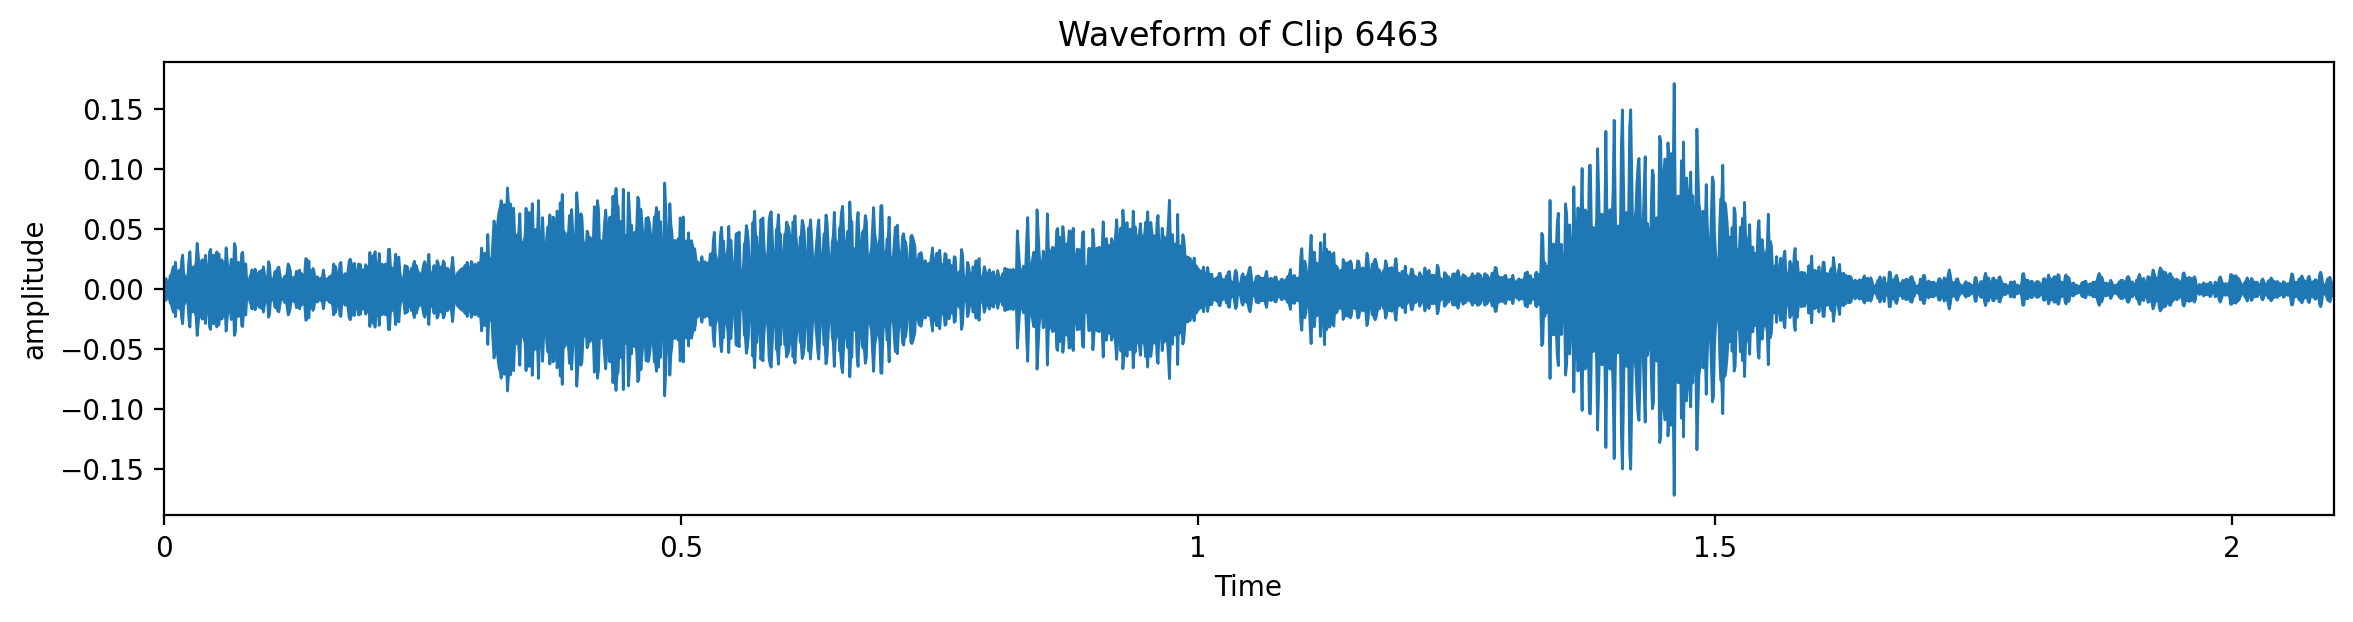

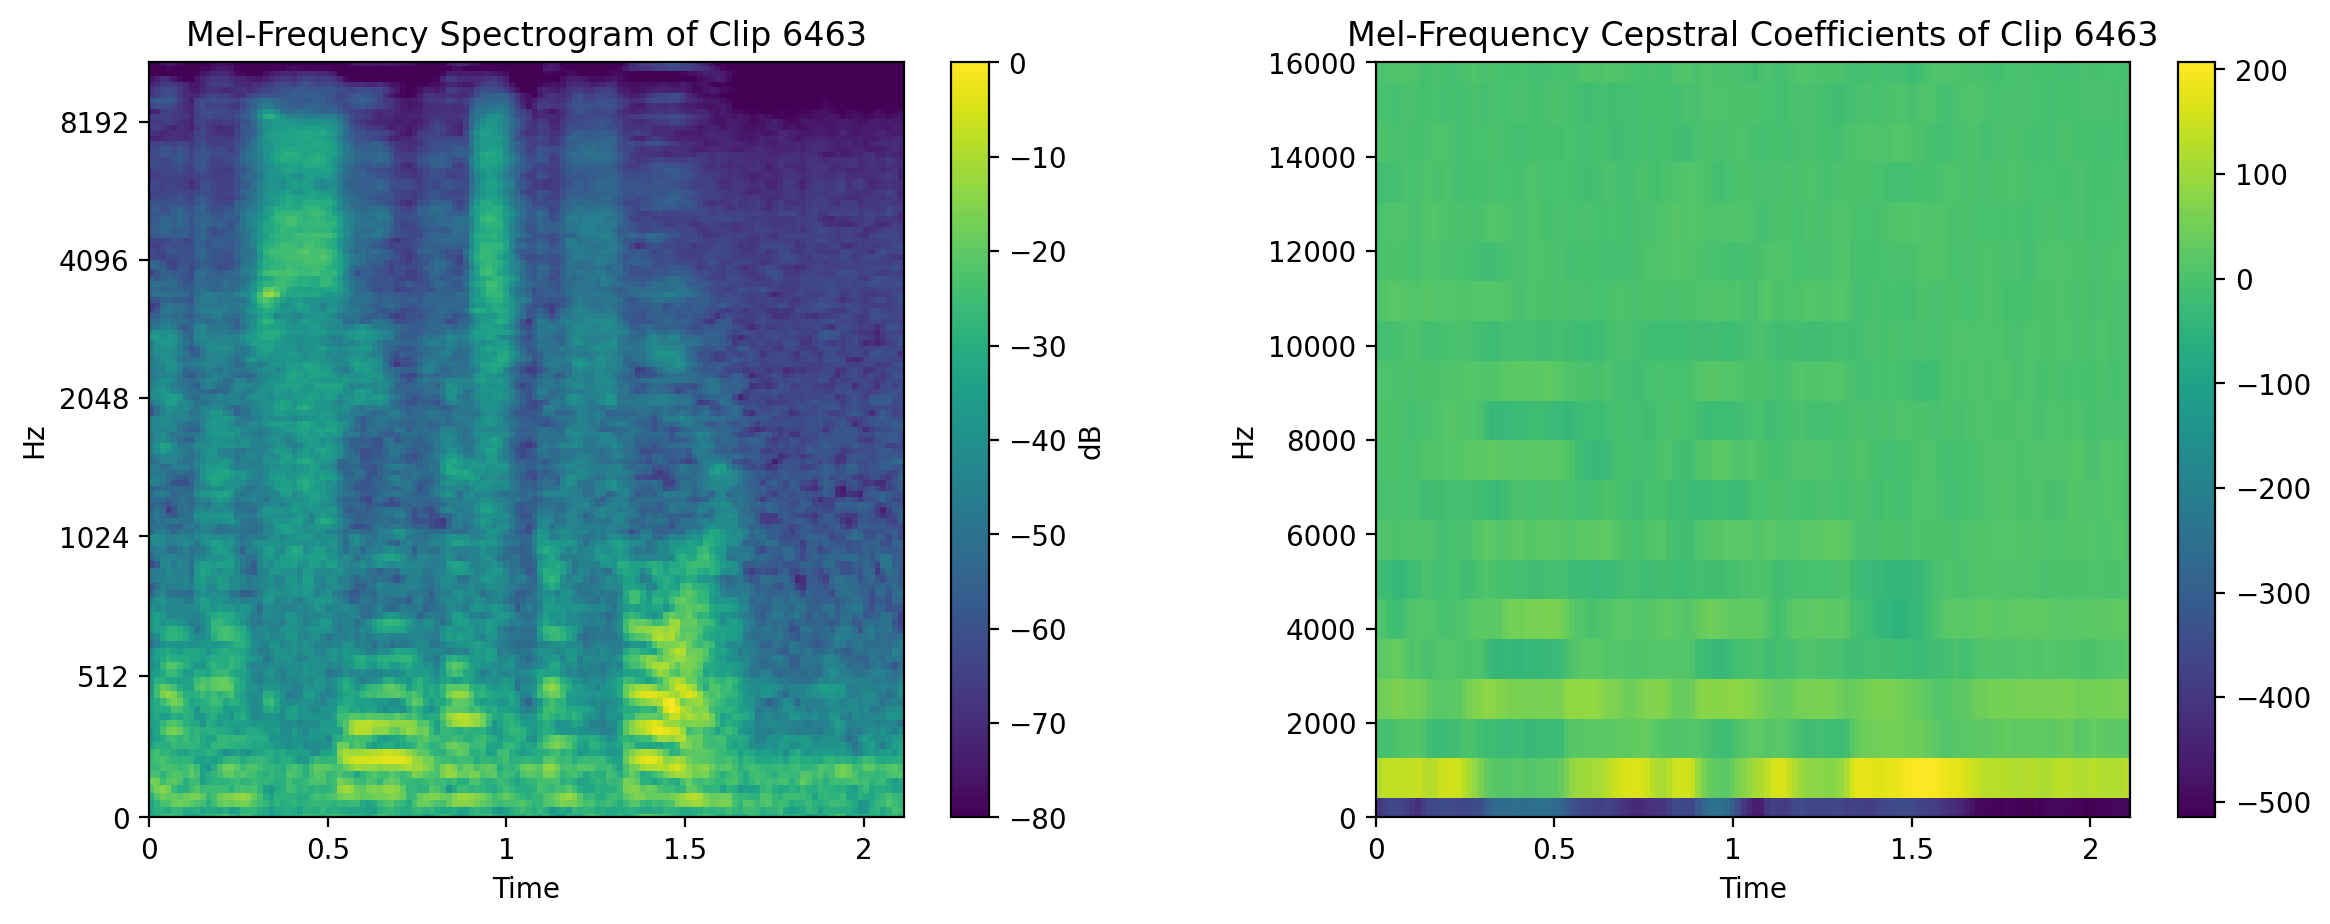

In [6]:
#-- Plot 1 -- Waveform ------------------------------------------------------------------------------------
wave = test['audio']
sample_rate = test['sample rate']

plt.figure(figsize=(14,3),dpi=200)
ld.waveplot(wave, sr=sample_rate)
plt.title('Waveform of Clip %-4d' % n)
plt.ylabel('amplitude')

#-- Plot 2 -- Mel-Frequency Spectrogram & Rolloff ----------------------------------------------------------
plt.figure(figsize=(14,5),dpi=200)
plt.subplots_adjust(wspace=0.3,hspace=0.3)

# change to decibels
S_dB = librosa.power_to_db(test['mel spectrogram'], ref=np.max)

plt.subplot(121)
librosa.display.specshow(data=S_dB,sr=sample_rate, x_axis='time',y_axis='mel',cmap='viridis')
plt.colorbar(label='dB')
plt.title('Mel-Frequency Spectrogram of Clip %-4d' % n)

#-- Plot 3 -- Mel-Frequency Cepstral Coefficients ----------------------------------------------------------
plt.subplot(122)
ld.specshow(test['mel cepstral'], sr=sample_rate, x_axis='time', y_axis='hz',cmap='viridis')
plt.title('Mel-Frequency Cepstral Coefficients of Clip %-4d' % n)
plt.colorbar();

# Prep and Save
normalize the data feature-wise and add padding so that each entry is the same size.

In [7]:
# drop unnecessary
audio = audio.drop(columns=['audio','sample rate'])
# convert mel spectrogram to decibels
audio['mel spectrogram'] = [librosa.power_to_db(entry, ref=np.max) for entry in audio['mel spectrogram']]

In [8]:
def min_max(data,column):
    '''returns the global min and max of the whole column'''
    local_min = []
    local_max = []
    for entry in data[column]:
        local_min.append(np.amin(entry))
        local_max.append(np.amax(entry))
    return min(local_min), max(local_max)

# normalize by feature
def normalize(data,column):
    feat_min,feat_max = min_max(data,column)
    array = data[column].to_numpy()
    array = (array-feat_min)/(feat_max-feat_min)
    return array

def concat(data,columns):
    new_col = []
    for index in data.index:
        for column in columns:
            entry = audio.loc[index][column]
            if column == columns[0]:
                flat_entry = entry
            else:
                flat_entry = np.concatenate((flat_entry,entry),axis=0)
        new_col.append(flat_entry)
    return new_col

In [9]:
print('Normalizing Features',end='')
for column in columns[3:]:
    audio[column] = normalize(audio,column)
print(' - Complete!')

print('Combining Images',end='')
audio['final'] = concat(audio,columns[3:])
print('     - Complete!')

audio = audio.drop(columns=columns[3:])

print('Padding Images',end='')
max_len = max([array.shape[1] for array in audio['final']])
for index in audio.index:
    entry = audio.loc[index]['final']
    matrix = []
    if entry.shape[1] != max_len:
        zeros = max_len - entry.shape[1]
        front = int(zeros/2)
        back = int(zeros-front)
        for array in entry:
            matrix.append(np.append(np.append(np.zeros(front),array),np.zeros(back)))
    if entry.shape[1] == max_len:
        matrix = entry
    audio.loc[index]['final'] = matrix
print('       - Complete!')

Normalizing Features - Complete!
Combining Images     - Complete!
Padding Images       - Complete!


In [10]:
# save images
print('Saving Images')
for count,index in enumerate(audio.index,start=1):
    entry = audio.loc[index]
    path = 'Data/Images/%s.png' % (entry['filename'][:-4])
    plt.imsave(path,entry['final'])
    print('%4d of %d complete (%d%%)' % (count,len(audio.index),(count/len(audio.index))*100),end='\r')
print('%-30s' % ('Complete')) 

Saving Images
Complete                      
